# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.638399,False,-1.539089
1,-1.669650,False,-1.747974
2,-0.185080,False,1.376023
3,-1.272653,True,2.029094
4,-0.436445,False,-0.270088
...,...,...,...
995,-0.705248,True,3.450241
996,0.041453,False,0.955865
997,0.338293,True,4.703778
998,0.100989,True,4.153770


<AxesSubplot:xlabel='v0'>

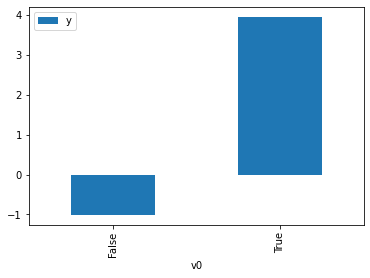

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

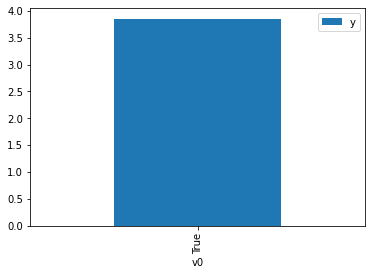

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.654515,False,1.238388,0.467795,2.137687
1,-1.187864,False,-2.838297,0.653666,1.529832
2,0.061698,False,0.315042,0.529191,1.889678
3,-2.155726,False,-3.459667,0.738203,1.354641
4,0.893528,False,0.428021,0.443212,2.256256
...,...,...,...,...,...
995,-1.062081,False,-1.746029,0.641762,1.558209
996,0.195660,False,-0.463577,0.515328,1.940513
997,0.684818,False,1.131846,0.464667,2.152077
998,0.803412,False,2.683890,0.452455,2.210165


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.465502,True,4.556681,0.416886,2.398737
1,-1.319095,True,3.757468,0.334116,2.992973
2,-0.683383,True,4.541488,0.395095,2.531035
3,-2.232987,True,3.378431,0.255651,3.911582
4,-1.354086,True,3.161947,0.330895,3.022110
...,...,...,...,...,...
995,-1.455692,True,3.803380,0.321631,3.109152
996,-1.753653,True,1.958031,0.295280,3.386615
997,-1.381505,True,2.815076,0.328382,3.045239
998,-0.726373,True,4.206185,0.390842,2.558580


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.908
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              4919.
Date:                Wed, 03 Aug 2022   Prob (F-statistic):                        0.00
Time:                        14:47:10   Log-Likelihood:                         -1424.0
No. Observations:                1000   AIC:                                      2852.
Df Residuals:                     998   BIC:                                      2862.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3933      0.025     55.201      0.000       1.344       1.443
x2             4.9239      0.053     93.587      0.000       4.821       5.027
==============================================================================
Omnibus:                        3.184   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                3.201
Skew:                          -0.114   Prob(JB):                        0.202
Kurtosis:                       2.843   Cond. No.                         2.19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""